In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load the DataFrame saved earlier, load and remove topic -1 early
df = pd.read_pickle("../data/data.pkl")
df = df[df["topic"] != -1].copy()

In [18]:
# Step 1: Convert postedDate → datetime and extract month
df["date"] = pd.to_datetime(df["postedDate"])
df["month"] = df["date"].dt.to_period("M")

# Step 2: Get top N most common topics
top_topics = df["topic_label"].value_counts().head(10).index

# Step 3: Filter to only top topics
filtered_df = df[df["topic_label"].isin(top_topics)].copy()

/tmp/ipykernel_612967/2835929092.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


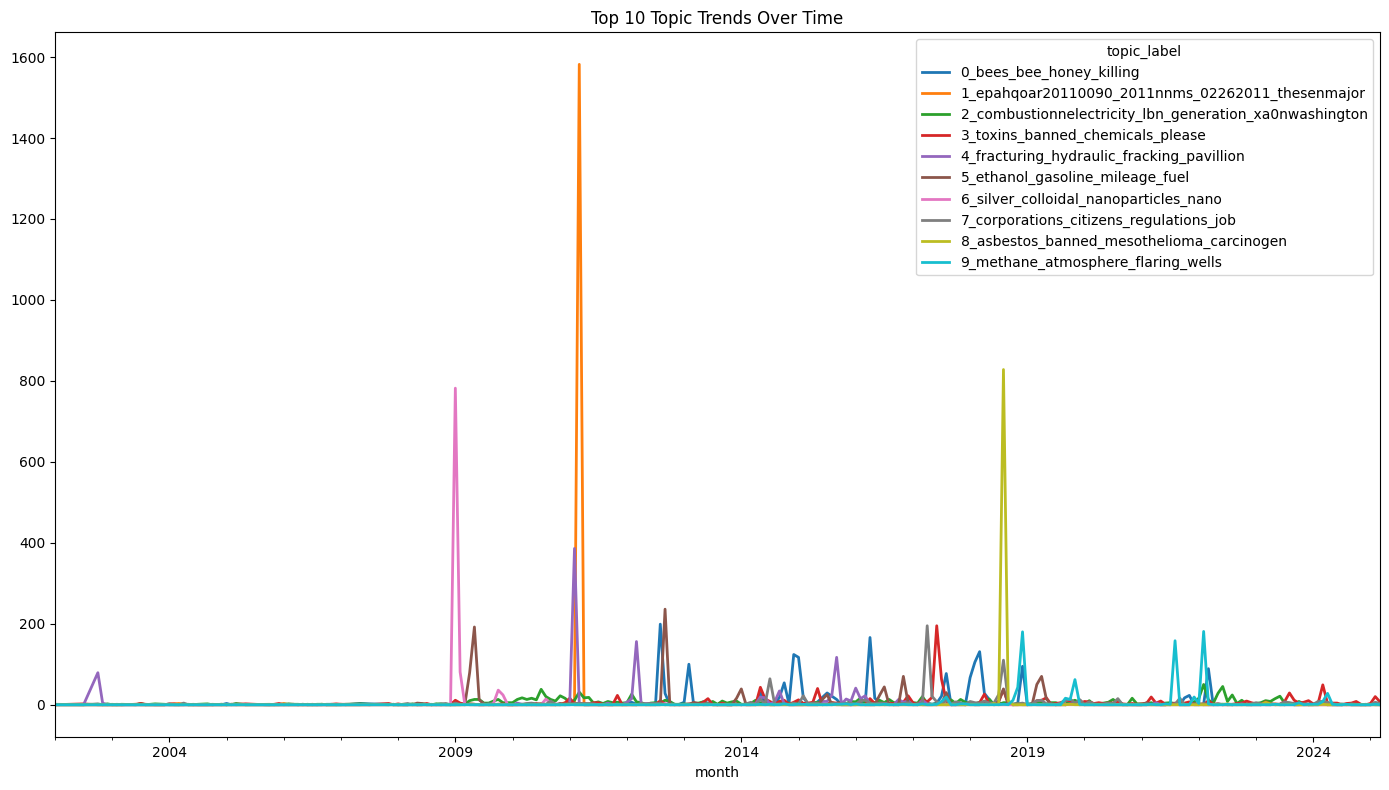

In [14]:
# Step 4: Group and plot
filtered_trends = (
    filtered_df.groupby(["month", "topic_label"])
    .size()
    .unstack(fill_value=0)
)

filtered_trends.plot(
    kind="line",
    figsize=(14, 8),
    linewidth=2,
    title="Top 10 Topic Trends Over Time"
)
# Save the figure
plt.tight_layout()  # optional, improves spacing
plt.savefig("../outputs/time_topictrend.png", dpi=300)
plt.show()

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X = np.vstack(df["embedding"].values)
labels = df["topic"].values
score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.086


Adding sentiment

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load model + tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Select the first 10 actual rows (after removing topic -1)
df_sample = df.iloc[:10].copy()

# Ensure all comments are valid strings
sample_comments = df_sample["processed_comment"].fillna("neutral").tolist()

# Run sentiment analysis
results = sentiment_pipeline(sample_comments)

# ✅ Check for length mismatch just in case
print("Sample size:", len(sample_comments))
print("Results size:", len(results))

# Add to the sample dataframe (not full df)
df_sample["sentiment_label"] = [r["label"] for r in results]
df_sample["sentiment_score"] = [r["score"] for r in results]

# Display to verify
df_sample[["processed_comment", "sentiment_label", "sentiment_score"]]


Device set to use cpu


Sample size: 10
Results size: 10


,processed_comment,sentiment_label,sentiment_score
0,RE Docket EPAR10OAR20190710 Federal Register N...,LABEL_1,0.660185
7,"Don t turn white , freedom is important. Nobod...",LABEL_2,0.666446
8,I found this regulation interesting because of...,LABEL_1,0.533829
9,Regarding the proposed regulation of wood burn...,LABEL_0,0.787296
10,I heat my shop and house with wood in our rura...,LABEL_0,0.584330
12,One of the main revisions this proposed rulema...,LABEL_0,0.584047
21,Many elderly people rely on wood heat as their...,LABEL_0,0.842510
23,We heat our home with a wood stove. In our are...,LABEL_0,0.667421
25,"I don t agree with this at all, I think it s a...",LABEL_0,0.924764
26,Trump s political appointees to the EPA caved ...,LABEL_0,0.776745


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(np.vstack(df["embedding"].values))
df["PCA1"] = pca_embeddings[:, 0]
df["PCA2"] = pca_embeddings[:, 1]

px.scatter(
    df,
    x="PCA1",
    y="PCA2",
    color="topic_label",
    hover_data=["processed_comment"],
    title="PCA of SBERT Embeddings"
).show()